# Import packages

In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.7 MB/s eta 0:00:00


In [2]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 11.0 MB/s eta 0:00:00


In [3]:
!pip install tensorflow transformers

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import transformers
import matplotlib.pyplot as plt
import numpy as np
import os
import contractions
import gc
import re
import seaborn as sns

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
print(transformers.__version__)

4.31.0


# Multilabeled Data

## Import Multi-labeled Data

In [ ]:
random_state = 42

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/audace_trial/classified_text/english_modern/classified_texts_07_03_2023.xlsx')

In [ ]:
df

In [ ]:
# Shuffle the dataframe
df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)


# Split the dataframe into training and testing sets
df_train_data, df_test_data = train_test_split(df, test_size=0.3, random_state=random_state)

In [ ]:
len(df_train_data)

In [ ]:
len(df_test_data)

In [ ]:
# Count the occurrences of each topic label
label_counts = df_train_data['Topic Label'].value_counts()

plt.figure(figsize=(15, 10))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.title('Topic Label Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# Truncate the topic labels
plt.xticks(range(len(label_counts.index)), [label[:15] + '...' if len(label) > 10 else label for label in label_counts.index], rotation=45)
for i, count in enumerate(label_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

In [ ]:
# Count the occurrences of each topic label
label_counts = df_test_data['Topic Label'].value_counts()

plt.figure(figsize=(15, 10))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.title('Topic Label Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# Truncate the topic labels
plt.xticks(range(len(label_counts.index)), [label[:15] + '...' if len(label) > 10 else label for label in label_counts.index], rotation=45)
for i, count in enumerate(label_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

## Pytorch Bert

### Data import


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
import urllib.request
import tarfile
import os
import copy
import sys
import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random as rn
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
from tensorflow.keras.utils import pad_sequences

In [ ]:
train_data = df_train_data.to_dict(orient='records')
test_data = df_test_data.to_dict(orient='records')
type(train_data)

In [ ]:
train_data[0].keys()

In [ ]:
train_texts, train_labels = list(zip(*map(lambda d: (d['Text'], d['Topic Label']), train_data)))
test_texts, test_labels = list(zip(*map(lambda d: (d['Text'], d['Topic Label']), test_data)))

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], test_texts))

len(train_tokens), len(test_tokens)

In [ ]:
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

In [ ]:
mlb = MultiLabelBinarizer()
train_labels_encoded = mlb.fit_transform(train_labels)
test_labels_encoded = mlb.transform(test_labels)

In [ ]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

### baseline

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

In [ ]:
baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression()).fit(train_texts, train_labels)

In [ ]:
baseline_predicted = baseline_model.predict(test_texts)

In [ ]:
print(classification_report(test_labels, baseline_predicted))

### Bert

### Start

In [ ]:
import gc

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
        self.attentions = None

    def forward(self, tokens, masks=None):
        output = self.bert(tokens, attention_mask=masks)
        dropout_output = self.dropout(output['pooler_output'])
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        self.attentions = output['attentions']
        return proba

In [ ]:
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
torch.cuda.empty_cache()

In [ ]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

In [ ]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()

In [ ]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

### model

In [ ]:
BATCH_SIZE = 16
EPOCHS = 2

In [ ]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_labels_encoded).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_labels_encoded).float()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

In [ ]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

In [ ]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
param_optimizer = list(bert_clf.sigmoid.named_parameters())
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

In [ ]:
param_optimizer

In [ ]:
optimizer_grouped_parameters

In [ ]:
optimizer = Adam(bert_clf.parameters(), lr=5e-6)

In [ ]:
loss_history = []
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        logits = bert_clf(token_ids, masks)

        loss_func = nn.BCELoss()

        batch_loss = loss_func(logits, labels)
        train_loss += batch_loss.item()
        gc.collect()

        bert_clf.zero_grad()
        batch_loss.backward()


        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()

        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        loss = train_loss / (step_num + 1)
        loss_history.append(loss)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(df_train) / BATCH_SIZE, train_loss / (step_num + 1)))

In [ ]:
bert_clf.eval()
bert_test_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()

        bert_test_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])

In [ ]:
print(classification_report(test_y, bert_test_predicted))

In [ ]:
plt.plot(loss_history)
plt.title('Loss of Bert model')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.savefig('Loss of Bert model.png')
plt.show

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(test_y, bert_test_predicted)
cm

In [ ]:
import seaborn as sn
sn.heatmap(cm, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix of BERT Model')
plt.savefig('Bert_conf_matrix.png')

In [ ]:
np.where(test_y != bert_test_predicted)[0]

In [ ]:
bert_clf.eval()
bert_train_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(train_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()

        bert_train_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])

In [ ]:
print(classification_report(train_y, bert_train_predicted))

## Tensorflow Bert

In [7]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd

In [8]:
# Load the dataset
df = pd.read_excel('/content/drive/MyDrive/audace_trial/classified_text/english_modern/classified_texts_07_03_2023_filtered.xlsx')

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Get the input texts and labels
train_texts = train_df['Text'].tolist()
train_labels = train_df['Topic Label'].tolist()
test_texts = test_df['Text'].tolist()
test_labels = test_df['Topic Label'].tolist()

# Encode the labels using LabelEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)
num_classes = len(label_encoder.classes_)


In [9]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the training texts
train_tokenized = tokenizer.batch_encode_plus(
    train_texts,
    padding='longest',
    truncation=True,
    max_length=256,
    return_tensors='tf'
)

# Tokenize the testing texts
test_tokenized = tokenizer.batch_encode_plus(
    test_texts,
    padding='longest',
    truncation=True,
    max_length=256,
    return_tensors='tf'
)


### model


In [10]:
# Load the BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
epochs = 15
batch_size = 16

In [12]:
# Convert the tokenized data to TensorFlow tensors
train_input_ids = tf.convert_to_tensor(train_tokenized['input_ids'])
train_attention_mask = tf.convert_to_tensor(train_tokenized['attention_mask'])
test_input_ids = tf.convert_to_tensor(test_tokenized['input_ids'])
test_attention_mask = tf.convert_to_tensor(test_tokenized['attention_mask'])

# Convert the labels to TensorFlow tensors
train_labels = tf.convert_to_tensor(train_labels_encoded)
test_labels = tf.convert_to_tensor(test_labels_encoded)

# Train the model
model.fit(
    x=(train_input_ids, train_attention_mask),
    y=train_labels,
    epochs=epochs,
    batch_size=batch_size,
    verbose=2
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(
    x=(test_input_ids, test_attention_mask),
    y=test_labels
)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/15
65/65 - 125s - loss: 2.3341 - accuracy: 0.2563 - 125s/epoch - 2s/step
Epoch 2/15
65/65 - 57s - loss: 1.6872 - accuracy: 0.5609 - 57s/epoch - 872ms/step
Epoch 3/15
65/65 - 56s - loss: 1.2578 - accuracy: 0.6799 - 56s/epoch - 861ms/step
Epoch 4/15
65/65 - 58s - loss: 0.9386 - accuracy: 0.7940 - 58s/epoch - 887ms/step
Epoch 5/15
65/65 - 56s - loss: 0.7098 - accuracy: 0.8511 - 56s/epoch - 863ms/step
Epoch 6/15
65/65 - 56s - loss: 0.4739 - accuracy: 0.9130 - 56s/epoch - 865ms/step
Epoch 7/15
65/65 - 56s - loss: 0.3074 - accuracy: 0.9526 - 56s/epoch - 862ms/step
Epoch 8/15
65/65 - 56s - loss: 0.2107 - accuracy: 0.9758 - 56s/epoch - 863ms/step
Epoch 9/15
65/65 - 56s - loss: 0.1385 - accuracy: 0.9874 - 56s/epoch - 863ms/step
Epoch 10/15
65/65 - 56s - loss: 0.1017 - accuracy: 0.9903 - 56s/epoch - 865ms/step
Epoch 11/15
65/65 - 56s - loss: 0.0743 - accuracy: 0.9942 - 56s/epoch - 864ms/step
Epoch 12/15
65/65 - 56s - loss: 0.0801 - accuracy: 0.9855 - 56s/epoch - 863ms/step
Epoch 13/15
65

In [13]:
# Get the predicted labels
predictions = model.predict((test_input_ids, test_attention_mask))
predicted_labels = tf.argmax(predictions.logits, axis=1).numpy()


9/9 [==============================] - 7s 502ms/step


In [14]:
predicted_labels = label_encoder.inverse_transform(predicted_labels)

In [15]:
true_labels = label_encoder.inverse_transform(test_labels.numpy())

In [16]:
from sklearn.metrics import classification_report

classification_report = classification_report(true_labels, predicted_labels)
print(classification_report)


                                                        precision    recall  f1-score   support

                            Business and Market Trends       0.73      0.69      0.71        16
                         COVID-19 Updates and Response       0.90      0.82      0.86        22
City Operations and Services in Winter (Vulnearbility)       0.73      0.92      0.81        24
               Climate Change and Environmental Impact       0.79      0.79      0.79        14
                         Daily Quotes and Social Media       0.95      0.95      0.95        19
                         Education and School Planning       0.53      0.56      0.55        16
                Floods and Home Safety (Vulnerability)       0.85      0.76      0.80        29
     Heatwave and Extreme Temperatures (Vulnerability)       0.83      0.53      0.65        19
                       Political Parties and Elections       0.62      0.71      0.67         7
                            Social Issu

# Binary Data

## Import binary-labeled Data

In [9]:
random_state = 42

In [10]:
df = pd.read_excel('/content/drive/MyDrive/audace_trial/classified_text/english_modern/classified_texts_07_03_2023_bi.xlsx')

In [11]:
df

,Text,Topic Label,Probability
0,QUEBEC - As Quebec health officials scrambled ...,neg,0.752367
1,As Quebec health officials scrambled in late s...,neg,0.905029
2,QUEBEC - The province wants to help Montreal o...,neg,0.672439
3,Within 48 hours of the provincial government s...,neg,0.413501
4,Verdun Hospital has been hit with the most sev...,neg,0.718635
...,...,...,...
1554,Power outages and flight disruptions reported ...,pos,0.402425
1555,? Much of Ontario and large parts of Quebec ar...,pos,0.554472
1556,"Close to 30,000 Quebecers were left without po...",neg,0.463640
1557,Southern Ontario was hit with a winter storm T...,pos,0.488597


In [12]:
# Split the positive data into training and testing sets
positive_data = df[df['Topic Label'] == 'pos']
negative_data = df[df['Topic Label'] == 'neg']
pos_train, pos_test = train_test_split(positive_data, test_size=0.4, random_state=42)

# Sample an equal number of negative samples for training and testing
neg_train = negative_data.sample(n=len(pos_train), random_state=42)
neg_test = negative_data.sample(n=len(pos_test), random_state=42)

# Concatenate the positive and negative samples for training and testing
train_data = pd.concat([pos_train, neg_train])
test_data = pd.concat([pos_test, neg_test])

# Shuffle the training and testing data
df_train_data = train_data.sample(frac=1, random_state=42)
df_test_data = test_data.sample(frac=1, random_state=42)

In [13]:
# # Shuffle the dataframe
# df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)


# # Split the dataframe into training and testing sets
# df_train_data, df_test_data = train_test_split(df, test_size=0.3, random_state=random_state)

In [14]:
len(df_train_data)

536

In [15]:
len(df_test_data)

358

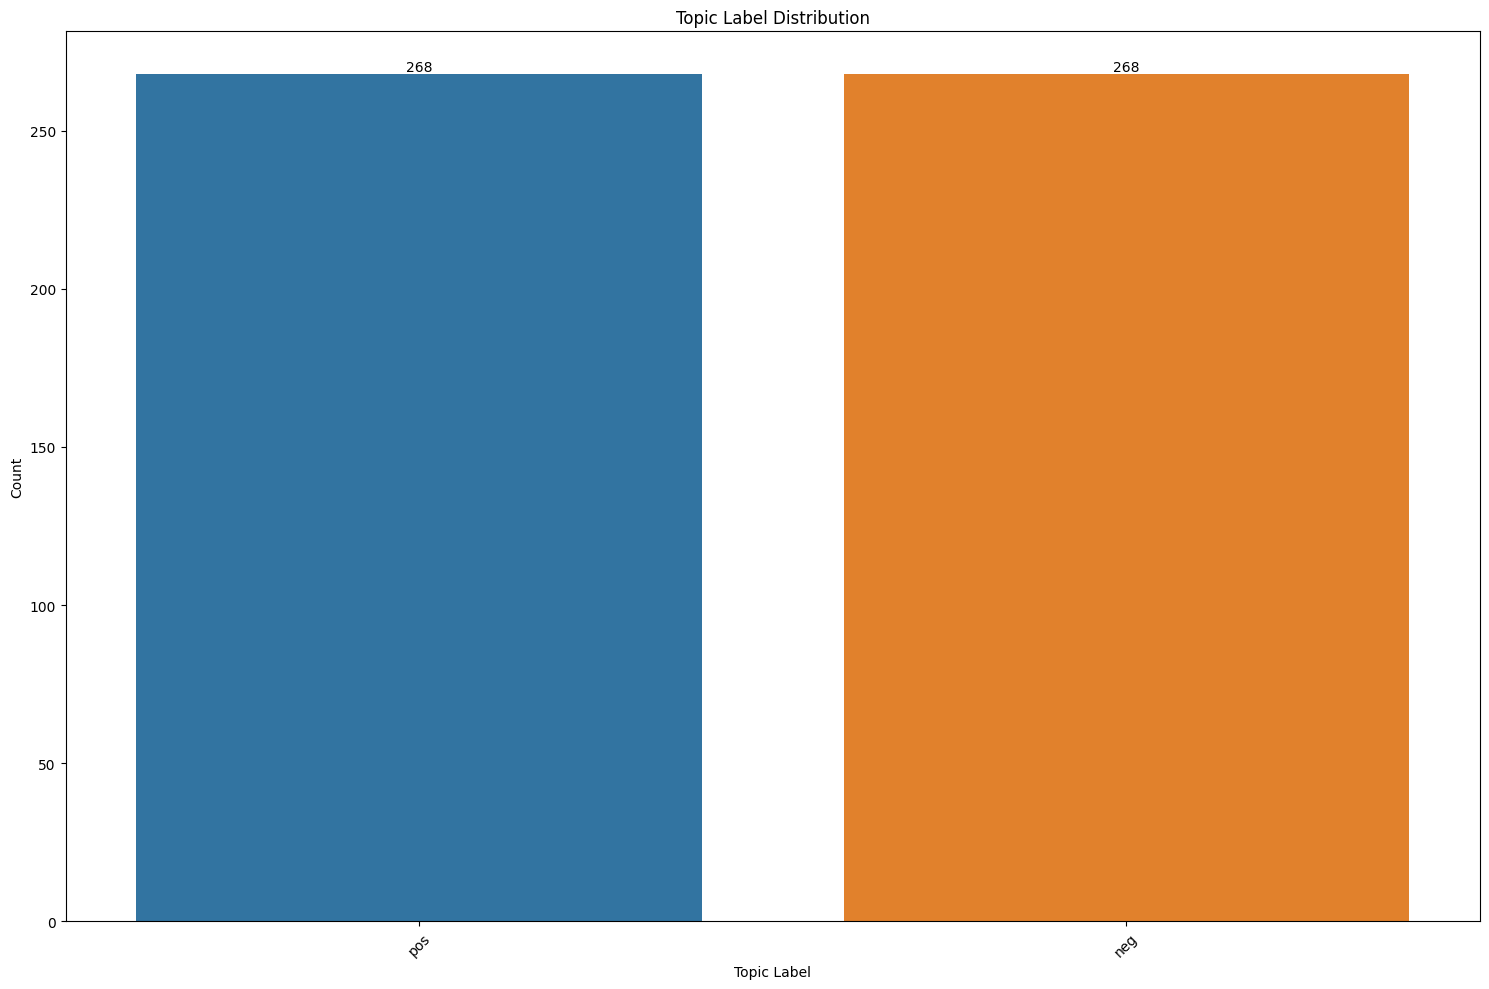

In [16]:
# Count the occurrences of each topic label
label_counts = df_train_data['Topic Label'].value_counts()

plt.figure(figsize=(15, 10))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.title('Topic Label Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# Truncate the topic labels
plt.xticks(range(len(label_counts.index)), [label[:15] + '...' if len(label) > 10 else label for label in label_counts.index], rotation=45)
for i, count in enumerate(label_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

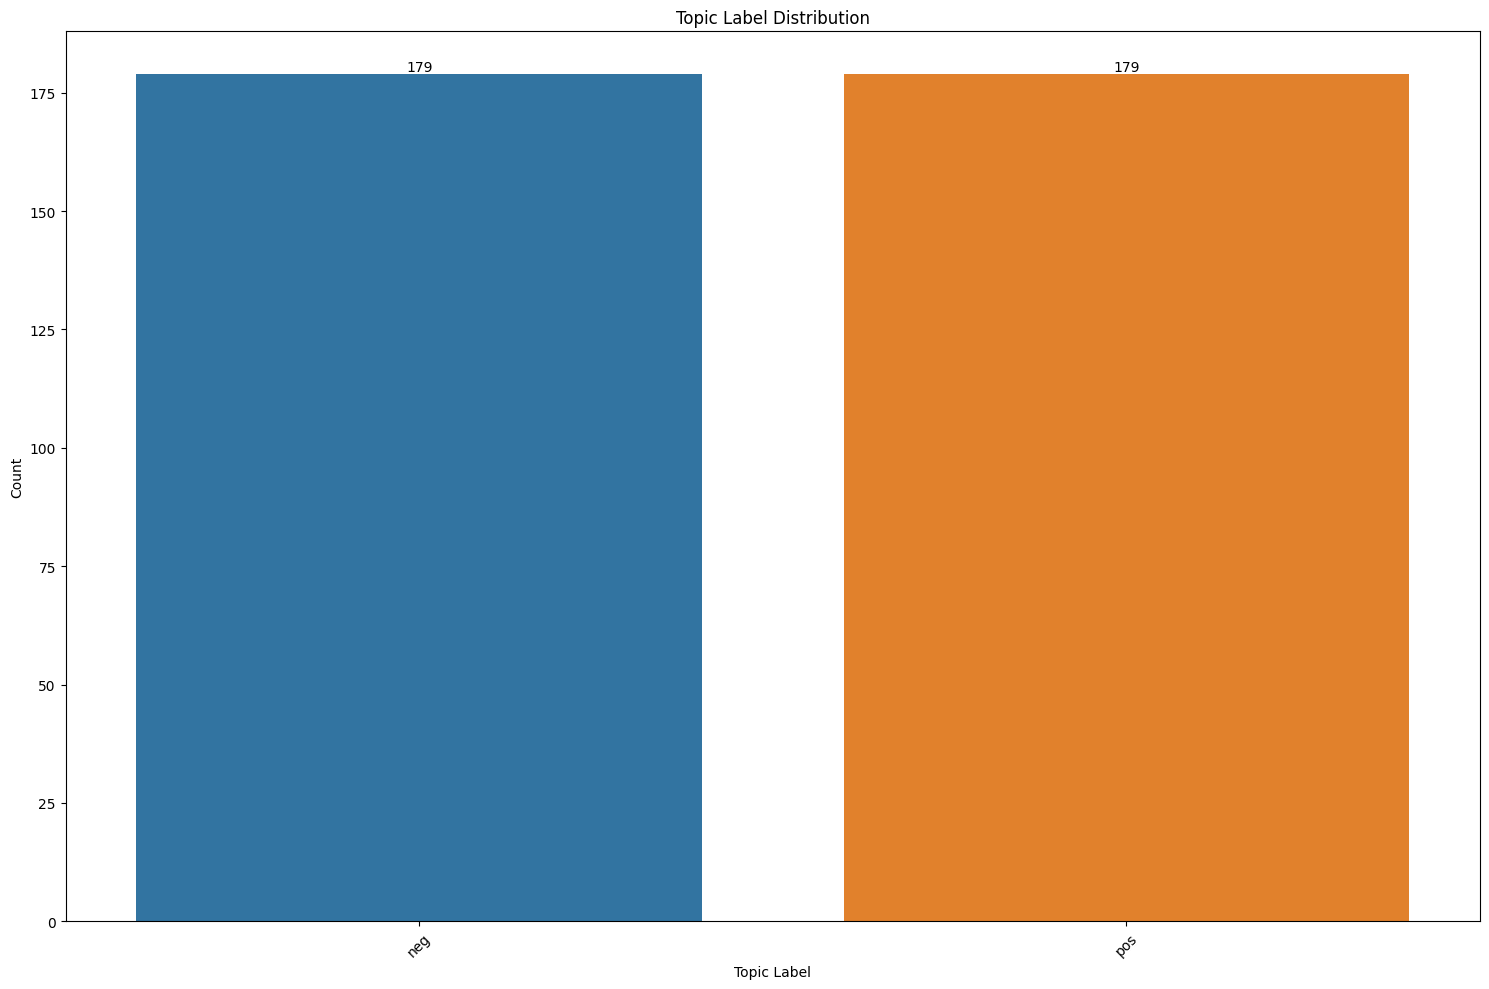

In [17]:
# Count the occurrences of each topic label
label_counts = df_test_data['Topic Label'].value_counts()

plt.figure(figsize=(15, 10))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.title('Topic Label Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# Truncate the topic labels
plt.xticks(range(len(label_counts.index)), [label[:15] + '...' if len(label) > 10 else label for label in label_counts.index], rotation=45)
for i, count in enumerate(label_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

## Pytorch Bert

### Data import


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
import urllib.request
import tarfile
import os
import copy
import sys
import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random as rn
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
from tensorflow.keras.utils import pad_sequences

In [ ]:
train_data = df_train_data.to_dict(orient='records')
test_data = df_test_data.to_dict(orient='records')
type(train_data)

list

In [ ]:
train_data[0].keys()

dict_keys(['Text', 'Topic Label', 'Probability'])

In [ ]:
train_texts, train_labels = list(zip(*map(lambda d: (d['Text'], d['Topic Label']), train_data)))
test_texts, test_labels = list(zip(*map(lambda d: (d['Text'], d['Topic Label']), test_data)))

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(402, 402, 270, 270)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], test_texts))

len(train_tokens), len(test_tokens)

(402, 270)

In [ ]:
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

((402, 512), (270, 512))

In [ ]:
train_y = np.array(train_labels) == 'pos'
test_y = np.array(test_labels) == 'pos'
train_y.shape, test_y.shape, np.mean(train_y), np.mean(test_y)

((402,), (270,), 0.5, 0.5)

In [ ]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

### baseline

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

In [ ]:
baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression()).fit(train_texts, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
baseline_predicted = baseline_model.predict(test_texts)

In [ ]:
print(classification_report(test_labels, baseline_predicted))

              precision    recall  f1-score   support

         neg       0.86      1.00      0.92       135
         pos       1.00      0.84      0.91       135

    accuracy                           0.92       270
   macro avg       0.93      0.92      0.92       270
weighted avg       0.93      0.92      0.92       270



### Bert

### Start

In [ ]:
import gc

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
        self.attentions = None

    def forward(self, tokens, masks=None):
        output = self.bert(tokens, attention_mask=masks)
        dropout_output = self.dropout(output['pooler_output'])
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        self.attentions = output['attentions']
        return proba

In [ ]:
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
torch.cuda.empty_cache()

In [ ]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'3001.513984M'

In [ ]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'3441.158656M'

### model

In [ ]:
BATCH_SIZE = 16
EPOCHS = 5

In [ ]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'2233.190912M'

In [ ]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
param_optimizer = list(bert_clf.sigmoid.named_parameters())
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

In [ ]:
param_optimizer

[]

In [ ]:
optimizer_grouped_parameters

[{'params': []}]

In [ ]:
optimizer = Adam(bert_clf.parameters(), lr=5e-6)

In [ ]:
loss_history = []
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        logits = bert_clf(token_ids, masks)

        loss_func = nn.BCELoss()

        batch_loss = loss_func(logits, labels)
        train_loss += batch_loss.item()
        gc.collect()

        bert_clf.zero_grad()
        batch_loss.backward()


        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()

        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        loss = train_loss / (step_num + 1)
        loss_history.append(loss)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(df_train_data) / BATCH_SIZE, train_loss / (step_num + 1)))

Epoch:  5
33/25.125 loss: 0.48340121262213764 


In [ ]:
bert_clf.eval()
bert_test_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()

        bert_test_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])

In [ ]:
print(classification_report(test_y, bert_test_predicted))

              precision    recall  f1-score   support

       False       0.75      0.76      0.76        68
        True       0.76      0.75      0.76        68

    accuracy                           0.76       136
   macro avg       0.76      0.76      0.76       136
weighted avg       0.76      0.76      0.76       136



<function matplotlib.pyplot.show(close=None, block=None)>

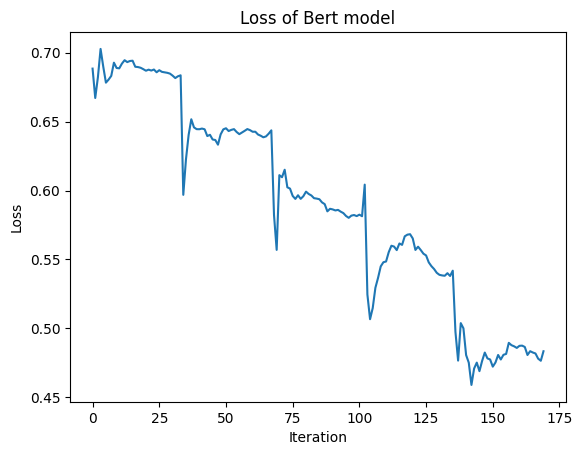

In [ ]:
plt.plot(loss_history)
plt.title('Loss of Bert model')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.savefig('Loss of Bert model.png')
plt.show

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(test_y, bert_test_predicted)
cm

array([[52, 16],
       [17, 51]])

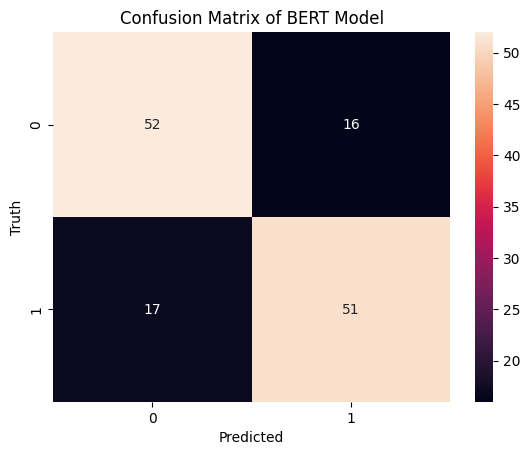

In [ ]:
import seaborn as sn
sn.heatmap(cm, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix of BERT Model')
plt.savefig('Bert_conf_matrix.png')

In [ ]:
np.where(test_y != bert_test_predicted)[0]

array([  7,   8,  11,  20,  31,  32,  34,  38,  43,  44,  49,  50,  54,
        58,  63,  68,  70,  80,  81,  84,  85,  88,  92,  98, 112, 113,
       116, 117, 122, 126, 129, 131, 135])

In [ ]:
bert_clf.eval()
bert_train_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(train_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()

        bert_train_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])

In [ ]:
print(classification_report(train_y, bert_train_predicted))

              precision    recall  f1-score   support

       False       0.49      0.44      0.46       268
        True       0.49      0.54      0.52       268

    accuracy                           0.49       536
   macro avg       0.49      0.49      0.49       536
weighted avg       0.49      0.49      0.49       536



## Tensorflow Bert

In [24]:
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.metrics import classification_report

In [25]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text and convert it to input tensors
train_inputs = tokenizer.batch_encode_plus(
    df_train_data['Text'].tolist(),
    padding='longest',
    truncation=True,
    max_length=256,
    return_tensors='tf'
)

test_inputs = tokenizer.batch_encode_plus(
    df_test_data['Text'].tolist(),
    padding='longest',
    truncation=True,
    max_length=256,
    return_tensors='tf'
)

train_input_ids = train_inputs['input_ids']
train_attention_mask = train_inputs['attention_mask']

test_input_ids = test_inputs['input_ids']
test_attention_mask = test_inputs['attention_mask']

# Convert the labels to numerical values
label_map = {'pos': 1, 'neg': 0}
train_labels = df_train_data['Topic Label'].map(label_map).tolist()
test_labels = df_test_data['Topic Label'].map(label_map).tolist()

In [26]:
train_input_ids = tf.convert_to_tensor(train_input_ids)
train_attention_mask = tf.convert_to_tensor(train_attention_mask)
train_labels = tf.convert_to_tensor(train_labels)

test_input_ids = tf.convert_to_tensor(test_input_ids)
test_attention_mask = tf.convert_to_tensor(test_attention_mask)
test_labels = tf.convert_to_tensor(test_labels)

### model

In [27]:
# Load the pre-trained BERT model for sequence classification
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

# Set up the input layers
input_ids = tf.keras.Input(shape=(256,), dtype=tf.int32)
attention_mask = tf.keras.Input(shape=(256,), dtype=tf.int32)

# Pass the inputs through the BERT model
outputs = bert_model(input_ids, attention_mask=attention_mask)

# Get the logits from the BERT model
logits = outputs.logits

# Create the classification model
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=logits)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
epochs = 4
batch_size = 16

In [29]:
# Train the model
model.fit([train_input_ids, train_attention_mask], train_labels, epochs=epochs, batch_size=batch_size, verbose=2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate([test_input_ids, test_attention_mask], test_labels)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/4
34/34 - 78s - loss: 0.6436 - accuracy: 0.6437 - 78s/epoch - 2s/step
Epoch 2/4
34/34 - 31s - loss: 0.4853 - accuracy: 0.8022 - 31s/epoch - 903ms/step
Epoch 3/4
34/34 - 31s - loss: 0.3586 - accuracy: 0.8507 - 31s/epoch - 909ms/step
Epoch 4/4
34/34 - 30s - loss: 0.2102 - accuracy: 0.9310 - 30s/epoch - 891ms/step
12/12 [==============================] - 9s 544ms/step - loss: 0.2268 - accuracy: 0.9274
Test Loss: 0.2268
Test Accuracy: 0.9274


In [30]:
# Convert the test labels from one-hot encoding to single-label format
test_predictions = np.argmax(model.predict([test_input_ids, test_attention_mask]), axis=1)

# Generate the classification report
report = classification_report(test_labels, test_predictions)
print(report)

12/12 [==============================] - 10s 558ms/step
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       179
           1       0.93      0.93      0.93       179

    accuracy                           0.93       358
   macro avg       0.93      0.93      0.93       358
weighted avg       0.93      0.93      0.93       358



In [31]:
# Convert the train labels from one-hot encoding to single-label format
train_predictions = np.argmax(model.predict([train_input_ids, train_attention_mask]), axis=1)

# Generate the classification report
report = classification_report(train_labels, train_predictions)
print(report)

17/17 [==============================] - 10s 615ms/step
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       268
           1       0.95      0.99      0.97       268

    accuracy                           0.97       536
   macro avg       0.97      0.97      0.97       536
weighted avg       0.97      0.97      0.97       536



In [33]:
model_dir = '/content/drive/MyDrive/audace_trial/model/BERT/Binary/2023_07_21_model_93'

In [32]:
model.save('/content/drive/MyDrive/audace_trial/model/BERT/Binary/2023_07_21_model_93')

In [34]:
tokenizer.save_pretrained(model_dir)

('/content/drive/MyDrive/audace_trial/model/BERT/Binary/2023_07_21_model_93/tokenizer_config.json',
 '/content/drive/MyDrive/audace_trial/model/BERT/Binary/2023_07_21_model_93/special_tokens_map.json',
 '/content/drive/MyDrive/audace_trial/model/BERT/Binary/2023_07_21_model_93/vocab.txt',
 '/content/drive/MyDrive/audace_trial/model/BERT/Binary/2023_07_21_model_93/added_tokens.json')